In [1]:
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error

from sklearn.pipeline import make_pipeline

%matplotlib inline

/Users/danieltaber/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
f = open('marathon df_2016_analysis', 'rb')   
df = pickle.load(f)  
f.close() 

# Exploratory data analysis

(array([  134.,  1239.,  3896.,  7275.,  7319.,  7004.,  5160.,  3357.,
         1331.,   750.]),
 array([ 131.38333333,  158.63166667,  185.88      ,  213.12833333,
         240.37666667,  267.625     ,  294.87333333,  322.12166667,
         349.37      ,  376.61833333,  403.86666667]),
 <a list of 10 Patch objects>)

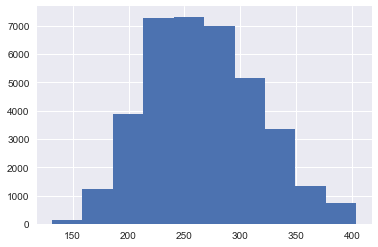

In [3]:
plt.hist(df.time)

In [4]:
df[['time', 'bib', 'age_ord', 'log_gini_start', 'start_range_percent', 'peak_time']].corr()

,time,bib,age_ord,log_gini_start,start_range_percent,peak_time
time,1.000000,0.770725,0.052565,0.635097,-0.507363,-0.321395
bib,0.770725,1.000000,0.021950,0.447730,-0.295010,-0.183058
age_ord,0.052565,0.021950,1.000000,-0.047885,0.003826,-0.058706
log_gini_start,0.635097,0.447730,-0.047885,1.000000,-0.577756,-0.266889
start_range_percent,-0.507363,-0.295010,0.003826,-0.577756,1.000000,0.459614
peak_time,-0.321395,-0.183058,-0.058706,-0.266889,0.459614,1.000000


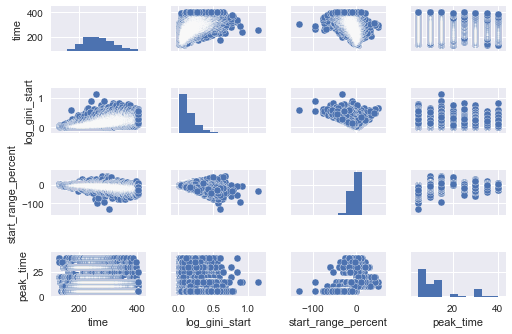

In [5]:
sns.pairplot(df[['time', 'log_gini_start', 'start_range_percent', 'peak_time']], 
                 size = 1.2, aspect=1.5)

# Linear regression

Start with a simple model to get a general sense of results.

In [34]:
lml = smf.ols('time ~ bib + peak_time + log_gini_start + start_range_percent + male + age_ord + USA', 
              data=df)
fit = lml.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                 1.483e+04
Date:                Mon, 09 Oct 2017   Prob (F-statistic):               0.00
Time:                        13:28:52   Log-Likelihood:            -1.7430e+05
No. Observations:               37465   AIC:                         3.486e+05
Df Residuals:                   37457   BIC:                         3.487e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept             199.9386      0.564    354.749      0.000       198.834   201.043
bib                     0.0017    9.8e-06    178.047      0.000         0.002     0.002
peak_time              -0.3982      0.017    -23.167      0.000        -0.432    -0.365
log_gini_start        132.3642      1.687     78.449      0.000       129.057   135.671
start_range_percent    -0.8187      0.022    -36.795      0.000        -0.862    -0.775
male                   -8.7296      0.287    -30.404      0.000        -9.292    -8.167
age_ord                 1.6213      0.066     24.722      0.000         1.493     1.750
USA                     3.1252      0.314      9.949      0.000         2.509     3.741
==============================================================================
Omnibus:                     1643.558   Durbin-Watson:                   1.320
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3212.702
Skew:                           0.327   Prob(JB):                         0.00
Kurtosis:                       4.276   Cond. No.                     3.94e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.94e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
df['y_pred'] = fit.fittedvalues
df['resid'] = fit.resid

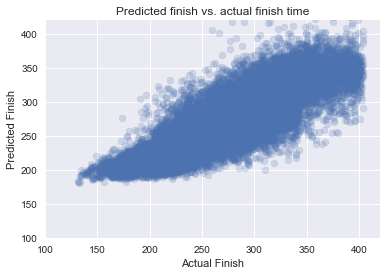

In [37]:
plt.scatter(df.time, df.y_pred, alpha = 0.20)
plt.title('Predicted finish vs. actual finish time')
plt.xlabel('Actual Finish')
plt.ylabel('Predicted Finish')
plt.xlim(100,420)
plt.ylim(100,420)
plt.show()

(array([  3.00000000e+00,   1.00000000e+01,   6.00000000e+01,
          5.74000000e+02,   6.15700000e+03,   1.80900000e+04,
          9.90700000e+03,   2.24100000e+03,   3.66000000e+02,
          5.70000000e+01]),
 array([-169.54408792, -139.89505293, -110.24601794,  -80.59698294,
         -50.94794795,  -21.29891296,    8.35012203,   37.99915703,
          67.64819202,   97.29722701,  126.946262  ]),
 <a list of 10 Patch objects>)

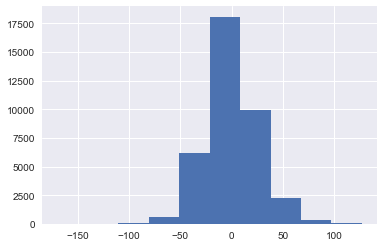

In [9]:
plt.hist(df.resid)

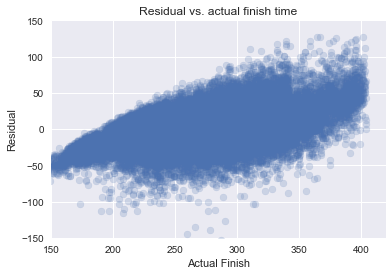

In [10]:
plt.scatter(df.time, df.resid, alpha = 0.20)
plt.title('Residual vs. actual finish time')
plt.xlabel('Actual Finish')
plt.ylabel('Residual')
plt.xlim(150,420)
plt.ylim(-150,150)
plt.show()

** Repeat in scikit-learn with train-test split **

In [11]:
y = df['time']
X = df[['bib', 'male', 'age_ord' , 'USA',
        'peak_time', 'log_gini_start', 'start_range_percent']]

In [12]:
lr = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.7385582390844273

In [14]:
X_train.shape

(26225, 7)

In [15]:
X_train = X_train.values.reshape((len(X_train),7));
y_train = y_train.reshape((len(y_train),1));
X_test = X_test.values.reshape((len(X_test),7));
y_test = y_test.reshape((len(y_test),1));

/Users/danieltaber/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app
/Users/danieltaber/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [16]:
deg = 8

train_error = np.empty(deg)
test_error = np.empty(deg)

for degree in range(deg):
    est = make_pipeline(PolynomialFeatures(degree), StandardScaler(), LinearRegression())
    est.fit(X_train, y_train)
    train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
    test_error[degree] = mean_squared_error(y_test, est.predict(X_test))

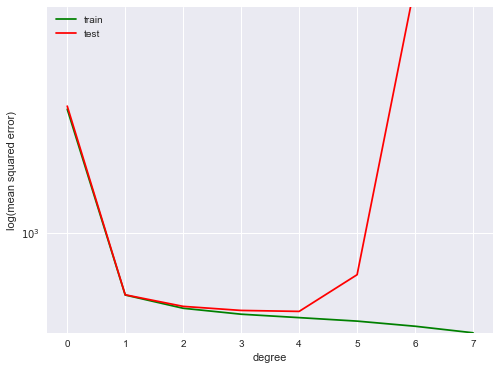

In [17]:
plt.figure(figsize=(8,6))
plt.semilogy(np.arange(deg), train_error, color='green', label='train')
plt.semilogy(np.arange(deg), test_error, color='red', label='test')
plt.ylim((0, 5000))
plt.ylabel('log(mean squared error)')
plt.xlabel('degree')
plt.legend(loc='upper left');

# Ridge regression

In [18]:
def plot_coefficients(est, ax, label=None, yscale='log'):
    coef = est.steps[-1][1].coef_.ravel() # flattens the data
    if yscale == 'log':
        ax.semilogy(np.abs(coef), marker='o', label=label)
        ax.set_ylim((1e-4, 1e10))
    else:
        ax.plot(np.abs(coef), marker='o', label=label)
        ax.set_ylabel('abs(coefficient)')
        ax.set_xlabel('coefficients')
        ax.set_xlim((1, 9))
        ax.set_ylim(-1000,1e6)

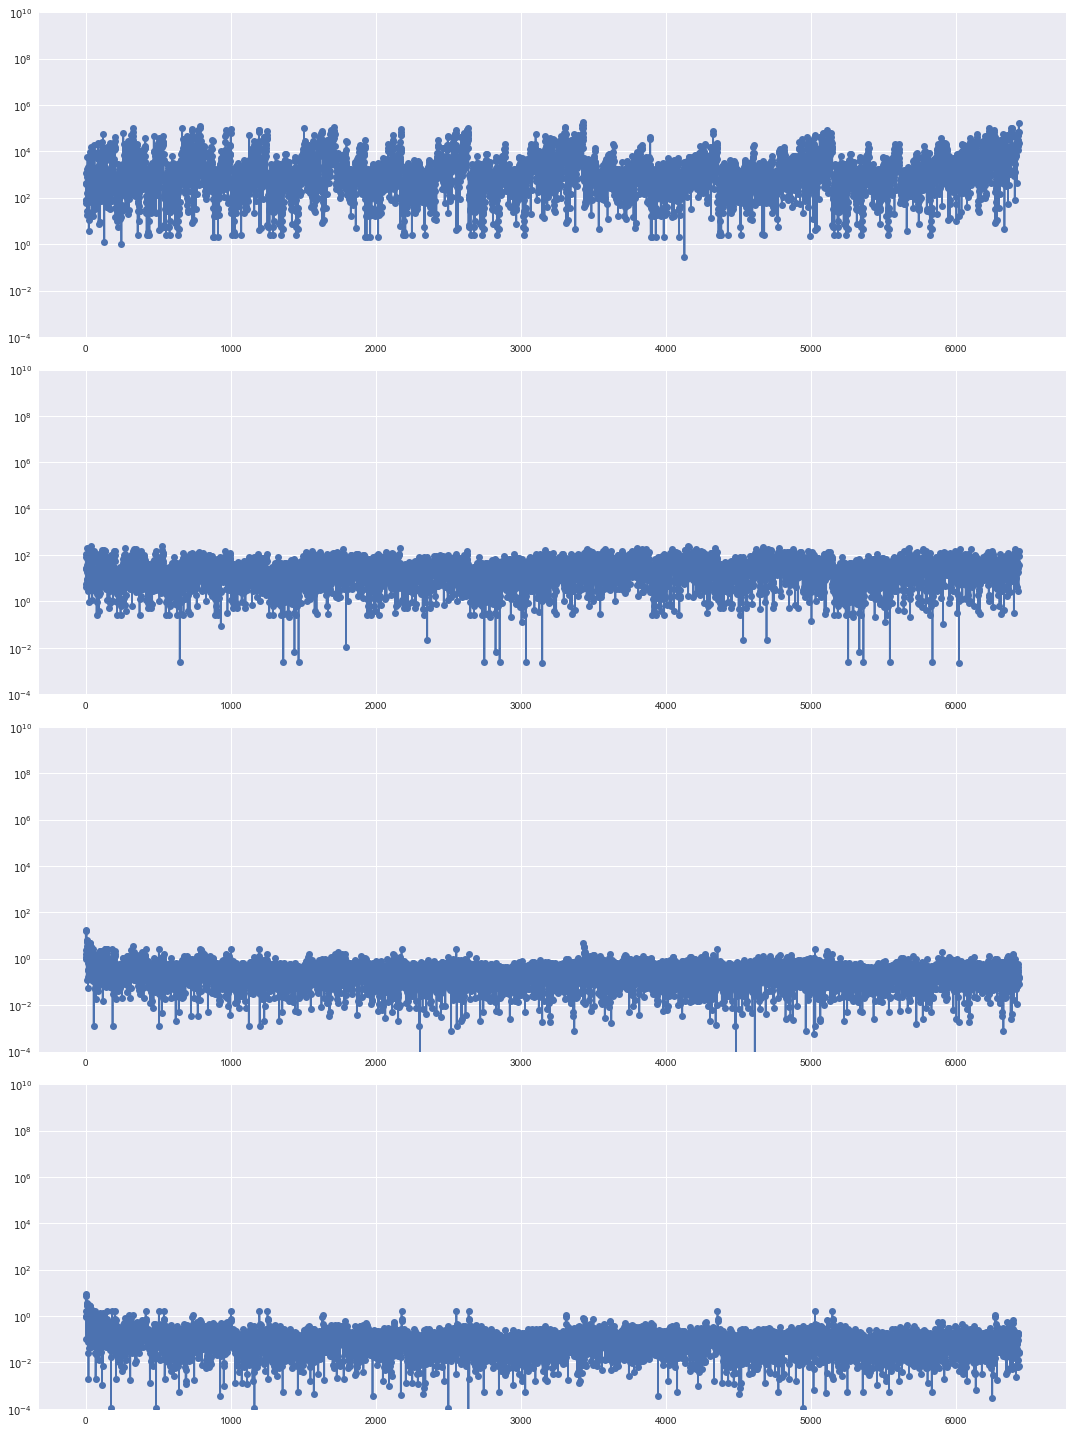

In [19]:
fig, ax_rows = plt.subplots(4, 1, figsize=(15, 20))
degree = 8
alphas = [1e-8, 1e-2, 100, 1000]

mse_tr_Ridge = []
mse_te_Ridge = []
r2_tr_Ridge = []
r2_te_Ridge = []

for alpha, ax_row in zip(alphas, ax_rows):
    ax_right = ax_row
    est = make_pipeline(PolynomialFeatures(degree), StandardScaler(), Ridge(alpha=alpha))
    est.fit(X_train, y_train)
    mse_tr_Ridge.append(mean_squared_error(y_train, est.predict(X_train)))
    mse_te_Ridge.append(mean_squared_error(y_test, est.predict(X_test)))
    r2_tr_Ridge.append(est.score(X_train,y_train))
    r2_te_Ridge.append(est.score(X_test,y_test))
    plot_coefficients(est, ax_right, label='Ridge(alpha=%r) coefficients' % alpha)
    
plt.tight_layout()

In [20]:
mse_te_Ridge

[2866347.0901677771, 41534.66187048854, 634.91045993973512, 599.72462271419215]

In [ ]:
plt.semilogx(alphas,mse_tr_Ridge,label='train',c='r')
plt.semilogx(alphas,mse_te_Ridge,label='test',c='b')
plt.ylim(400,7000)
plt.legend()

In [ ]:
plt.semilogx(alphas,r2_tr_Ridge,label='train',c='r')
plt.semilogx(alphas,r2_te_Ridge,label='test',c='b')
plt.ylim(0.5,1)
plt.legend()

# Cross-validation

In [26]:
degree = 8
est = make_pipeline(PolynomialFeatures(degree), 
                    StandardScaler(), 
                    RidgeCV(cv=5,alphas=(1e-2,1e-1, 100)))

In [27]:
est.fit(X_train, y_train)
print('Train R^2: ',est.score(X_train, y_train))
print('Train MSE:', 
      mean_squared_error(y_train, est.predict(X_train)))
print('Test R^2: ', est.score(X_test, y_test))
print('Test MSE:', 
      mean_squared_error(y_test, est.predict(X_test)))

Train R^2:  0.775558751652
Train MSE: 541.103759543
Test R^2:  0.742342203911
Test MSE: 634.91045994


In [28]:
est.fit(X, y)
print('Overall R^2:',est.score(X, y))
print('Overall MSE:', mean_squared_error(y, est.predict(X)))

Overall R^2: 0.775067211531
Overall MSE: 545.892153852


In [29]:
df['y_pred2'] = est.predict(X)

# Plot results

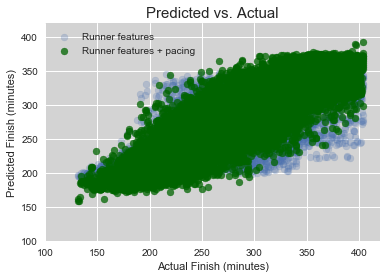

In [35]:
#Actual vs predicted finishes
fig,ax = plt.subplots(1,1)
plt.scatter(df.time, df.y_pred, label = 'Runner features', alpha = 0.25)
plt.scatter(df.time, df.y_pred2, label = 'Runner features + pacing', color = 'darkgreen', alpha = 0.75)
#plt.scatter(df.time, df.y_pred3, label = 'Better fitness measure', color = 'orange', alpha = 0.75)
plt.title('Predicted vs. Actual', size = 15)
plt.xlabel('Actual Finish (minutes)')
plt.ylabel('Predicted Finish (minutes)')
ax.legend()
ax.set_facecolor('lightgray')
plt.xlim(100,420)
plt.ylim(100,420)
plt.show()

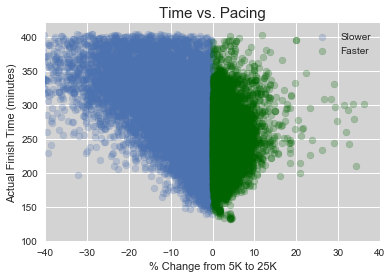

In [38]:
#Plot final time vs change in pace 
fig,ax = plt.subplots(1,1)

plt.scatter(df[df.start_range_percent<0].start_range_percent, 
            df[df.start_range_percent<0].time , label = 'Slower', alpha = 0.25)
plt.scatter(df[df.start_range_percent>0].start_range_percent, 
            df[df.start_range_percent>0].time , label = 'Faster', alpha = 0.25, color = 'darkgreen')
plt.title('Time vs. Pacing', size = 15)
plt.xlabel('% Change from 5K to 25K')
plt.ylabel('Actual Finish Time (minutes)')
ax.legend()
ax.set_facecolor('lightgray')
plt.xlim(-40,40)
plt.ylim(100,420)
plt.show()

# Predict times for specific characteristics

Use the code below to predict times for specific combinations of feature levels (e.g., American man, age 30-34, peaks at 15K, etc.)

In [39]:
X.head()

,bib,male,age_ord,USA,peak_time,log_gini_start,start_range_percent
0,3,1,3.0,0,40,0.056440,4.343330
1,1,1,2.0,0,40,0.053428,4.239917
2,7,1,1.0,0,40,0.053442,4.239917
3,6,1,1.0,0,35,0.050409,4.136505
4,8,1,2.0,0,20,0.060392,4.338843


In [40]:
X_new = X.iloc[0]

In [41]:
# Set characteristics to predict
X_new
X_new.bib = 35728
X_new.male = 0
X_new.age_ord = 7.0
X_new.USA = 1
X_new.peak_time = 15
X_new.log_gini_start = 0.040255
X_new.start_range_percent = -1.766438
print (X_new)

/Users/danieltaber/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


bib                    35728.000000
male                       0.000000
age_ord                    7.000000
USA                        1.000000
peak_time                 15.000000
log_gini_start             0.040255
start_range_percent       -1.766438
Name: 0, dtype: float64


In [42]:
est.predict(X_new)

/Users/danieltaber/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 269.20825857])